## Bayesian Modeling ##

In [1]:
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [3]:
# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

In [4]:
# 导入模型
from src.Bayesian_new import *

### 0. Unit Test

#### 0.1 Base Test

In [ ]:
p = Partition(4,4)

In [ ]:
p.prototypes

In [ ]:
p.calc_likelihood_entry(5, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.4,0.3,0.2],[0.4,0.2,0.3,0.1]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

In [ ]:
p.calc_likelihood_entry(2, (np.array([[0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,0,1])), 2.)

In [ ]:
pl = PartitionLikelihood(BaseSet(range(10)), p)

In [ ]:
pl.h_set

In [ ]:
pl.get_likelihood((np.array([[0.1,0.2,0.3,0.4],[0.05,0.02,0.53,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,1,0])), beta=15., normalized=True)

In [ ]:
spl = SoftPartitionLikelihood(BaseSet(range(10)), p, np.exp(np.linspace(0,5,10)))

In [ ]:
spl.get_likelihood((np.array([[0.1,0.2,0.3,0.4],[0.05,0.02,0.53,0.4],[0.1,0.2,0.3,0.4]]), np.array([3,2,3]), np.array([1,1,0])), normalized=True)

In [ ]:
learning_data

#### 0.2 Model Test

#### (1) Base model

In [5]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 模型拟合
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==2:
        condition = subject_data['condition'].iloc[0]
        model = SingleRationalModel(config_base, condition=condition)
        print(iSub)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values)
        step_results = model.fit_trial_by_trial(s_data)
        fitting_results[iSub] = {
            'condition': condition,
            'step_results': step_results
        }

2


  0%|          | 0/704 [00:00<?, ?it/s]/home/yangjiong/CategoryLearning/src/Bayesian_new/inference_engine/bayesian_engine.py:167: RuntimeWarning: invalid value encountered in true_divide
  posterior /= np.sum(posterior)
100%|██████████| 704/704 [01:22<00:00,  8.48it/s]


In [8]:
sub_results = fitting_results[1]

In [ ]:
step_results = sub_results['step_results']

#### (2) Forget model

In [25]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [ ]:
# 模型拟合
fitting_results = {}

for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
    if iSub==2:
        condition = subject_data['condition'].iloc[0]
        model_fgt = ForgetModel(config_fgt, condition=condition)
        print(iSub)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        optimize_results = model_fgt.optimize_params(s_data)
        fitting_results[iSub] = {
            'condition': condition,
            'best_params': optimize_results['best_params'],
            'best_error': optimize_results['best_error'],
            'best_step_results': optimize_results['best_step_results'],
            'optimize_results': optimize_results
        }

In [ ]:
sub_results = fitting_results[1]['optimize_results']

### 1. Base/ rational ###

In [7]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [ ]:
# 封装单个被试的拟合过程
def process_subject(iSub, subject_data, config):
    condition = subject_data['condition'].iloc[0]
    model_base = SingleRationalModel(config, condition=condition)
    
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
              subject_data["choice"].values,
              subject_data["feedback"].values)
    step_results = model_base.fit_trial_by_trial(s_data)

    return {
        'iSub': iSub,
        'condition': condition,
        'step_results': step_results
    }

# 并行拟合主流程
def parallel_fitting(learning_data, config, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_subject)(iSub, sub_data, config)
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [ ]:
if __name__ == '__main__':
    fitting_results = parallel_fitting(learning_data, config_base, n_jobs=24)

In [12]:
sub_results = fitting_results[1]

In [ ]:
sub_step_results = sub_results['step']

In [16]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_new'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Base_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

['/home/yangjiong/CategoryLearning/results/Bayesian_new/M_Base_fitting_results.joblib']

In [22]:
# 导入模型分析
import src.Bayesian.utils.model_evaluation as model_eval
importlib.reload(model_eval)
from src.Bayesian.utils.model_evaluation import ModelEval

model_eval = ModelEval()

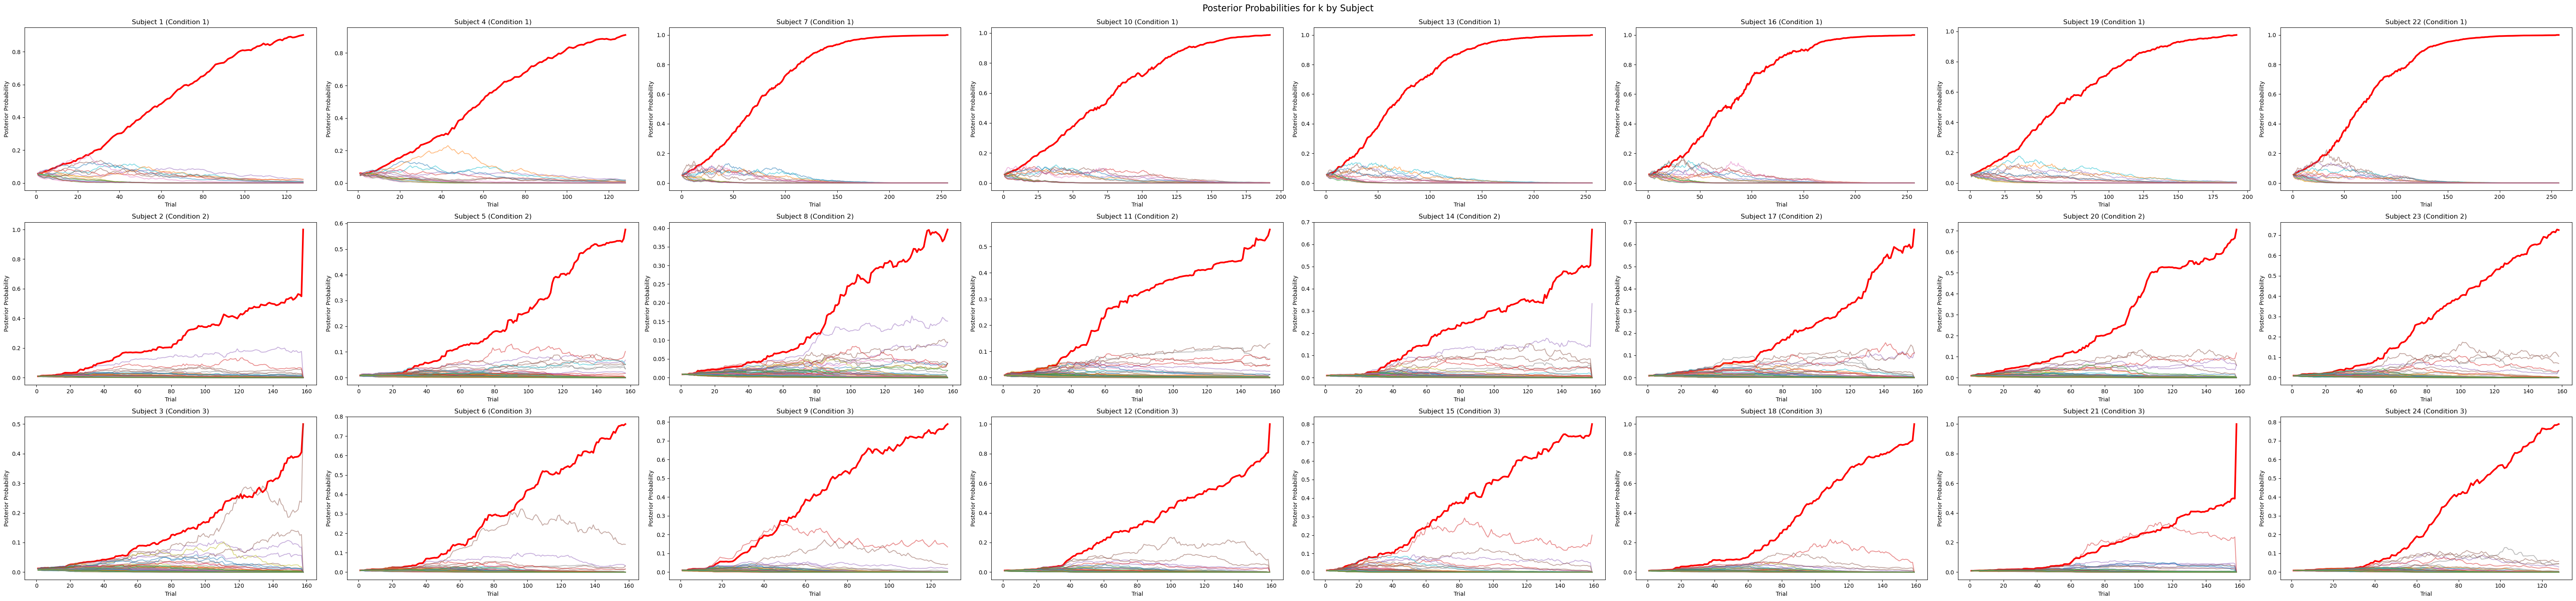

In [23]:
# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Base_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Base_posteriors.png')


In [ ]:
# 加载拟合结果
fitting_results = joblib.load(result_path / 'M_Base_fitting_results.joblib')

# 绘制最优参数变化图
# model_eval.plot_params_over_trials(fitting_results, 'best_beta', result_path / f'M_Base_beta.png')

# # 绘制k后验概率变化图
# model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Base_posteriors.png')

# 计算预测准确率
# predictive_results = {}
# for iSub, fit_result in fitting_results.items():
#     subject_data = learning_data[learning_data['iSub'] == iSub]
#     step_results = fit_result['step_results']
#     condition = fit_result['condition']
    
#     predictions = model_eval.calculate_predictions(model_base, subject_data, step_results)
#     sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
    
#     predictive_results[iSub] = {
#         'condition': condition,
#         'step_results': step_results,
#         'predictions': predictions,
#         'sliding_accuracy': sliding_accuracy
#     }

# # 绘制预测准确率变化图
# filename = f'M_Base_predictive_accuracy.png'
model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 2. + Forgetting ###

In [27]:
import src.Bayesian_new.problems.forget as forget
importlib.reload(forget)
from src.Bayesian_new.problems.forget import ForgetModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_fgt

In [28]:
# 封装单个被试的拟合过程
def process_subject(iSub, subject_data, config):
    condition = subject_data['condition'].iloc[0]
    model_fgt = ForgetModel(config, condition=condition)
    
    s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
            subject_data["choice"].values,
            subject_data["feedback"].values, 
            subject_data["category"].values)
    optimize_results = model_fgt.optimize_params(s_data)

    return {
        'iSub': iSub,
        'condition': condition,
        'optimize_results': optimize_results
    }

# 并行拟合主流程
def parallel_fitting(learning_data, config, n_jobs):
    """并行拟合所有被试"""
    subjects = list(learning_data.groupby('iSub'))
    
    # 使用并行计算
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_subject)(iSub, sub_data, config)
        for iSub, sub_data in tqdm(subjects, desc="Processing Subjects")
    )
    
    # 整理结果到字典
    fitting_results = {res['iSub']: res for res in results}
    return fitting_results

In [ ]:
if __name__ == '__main__':
    fitting_results = parallel_fitting(learning_data, config_fgt, n_jobs=24)

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Fgt_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

In [ ]:
# 加载拟合结果
fitting_results = joblib.load(result_path / 'M_Fgt_fitting_results.joblib')

# 绘制后验概率变化图
filename = f'M_Fgt_posteriors.png'
model_eval.plot_posterior_probabilities(fitting_results, result_path / filename)

# 计算预测准确率
predictive_results = {}
for iSub, fit_result in fitting_results.items():
    try:
        subject_data = learning_data[learning_data['iSub'] == iSub]
        step_results = fit_result['step_results']
        condition = fit_result['condition']
        
        predictions = model_eval.calculate_predictions(model_forget, subject_data, step_results)
        sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
        
        predictive_results[iSub] = {
            'condition': condition,
            'step_results': step_results,
            'predictions': predictions,
            'sliding_accuracy': sliding_accuracy
        }
    except Exception as e:
        print(f"Error processing predictions for subject {iSub}: {str(e)}")
        continue

# 绘制预测准确率变化图
filename = f'M_Fgt_predictive_accuracy.png'
model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 3. + Decision Noise ###

In [ ]:
# 导入模型
import src.Bayesian.M_dec as model_decision
importlib.reload(model_decision)
from src.Bayesian.M_dec import M_Dec

import src.Bayesian.config as config
importlib.reload(config)
from src.Bayesian.config import config_dec
model_decision = M_Dec(config_dec)

model_decision.set_centers(all_centers)

In [ ]:
# 模型拟合
fitting_results = {}
for iSub, subject_data in learning_data.groupby('iSub'):
    step_results = model_decision.fit_trial_by_trial(subject_data)
    fitting_results[iSub] = {
        'condition': subject_data['condition'].iloc[0],
        'step_results': step_results
    }

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Dec_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

In [ ]:
# 加载拟合结果
fitting_results = joblib.load(result_path / 'M_Dec_fitting_results.joblib')

# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'beta', result_path / f'M_Dec_beta.png')
model_eval.plot_params_over_trials(fitting_results, 'phi', result_path / f'M_Dec_phi.png')

# 绘制k的后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Dec_posteriors.png')

# 计算预测准确率
predictive_results = {}
for iSub, fit_result in fitting_results.items():
    try:
        subject_data = learning_data[learning_data['iSub'] == iSub]
        step_results = fit_result['step_results']
        condition = fit_result['condition']
        
        predictions = model_eval.calculate_predictions(model_decision, subject_data, step_results)
        sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
        
        predictive_results[iSub] = {
            'condition': condition,
            'step_results': step_results,
            'predictions': predictions,
            'sliding_accuracy': sliding_accuracy
        }
    except Exception as e:
        print(f"Error processing predictions for subject {iSub}: {str(e)}")
        continue

# 绘制预测准确率变化图
filename = f'M_Dec_predictive_accuracy.png'
model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 4. + Perceptive Noise ###

In [ ]:
learning_data = pd.read_csv(processed_path / 'Task2_processed_perceived.csv')

In [ ]:
# 导入基线模型
import src.Bayesian.M_base as model_base
importlib.reload(model_base)
from src.Bayesian.M_base import M_Base

import src.Bayesian.config as config
importlib.reload(config)
from src.Bayesian.config import config_base
model_base = M_Base(config_base)

model_base.set_centers(all_centers)

In [ ]:
# 模型拟合
fitting_results = {}
for iSub, subject_data in learning_data.groupby('iSub'):
    step_results = model_base.fit_trial_by_trial(subject_data)
    fitting_results[iSub] = {
        'condition': subject_data['condition'].iloc[0],
        'step_results': step_results
    }

In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian'
os.makedirs(result_path, exist_ok=True)

filename = f'M_Perc_fitting_results.joblib'
joblib.dump(fitting_results, result_path / filename)

In [ ]:
# 加载拟合结果
fitting_results = joblib.load(result_path / 'M_Perc_fitting_results.joblib')

# 绘制最优参数变化图
model_eval.plot_params_over_trials(fitting_results, 'beta', result_path / f'M_Perc_beta.png')

# 绘制k后验概率变化图
model_eval.plot_posterior_probabilities(fitting_results, result_path / f'M_Perc_posteriors.png')

# 计算预测准确率
predictive_results = {}
for iSub, fit_result in fitting_results.items():
    subject_data = learning_data[learning_data['iSub'] == iSub]
    step_results = fit_result['step_results']
    condition = fit_result['condition']
    
    predictions = model_eval.calculate_predictions(model_base, subject_data, step_results)
    sliding_accuracy = model_eval.calculate_sliding_accuracy(predictions)
    
    predictive_results[iSub] = {
        'condition': condition,
        'step_results': step_results,
        'predictions': predictions,
        'sliding_accuracy': sliding_accuracy
    }

# 绘制预测准确率变化图
filename = f'M_Perc_predictive_accuracy.png'
model_eval.plot_predictive_accuracy(predictive_results, result_path / filename)

### 5. + Attention Weight ###

In [ ]:
# 导入基线模型
import src.Bayesian.M_base as model_base
importlib.reload(model_base)
from src.Bayesian.M_base import M_Base

import src.Bayesian.config as config
importlib.reload(config)
from src.Bayesian.config import config_base
model_base = M_Base(config_base)

model_base.set_centers(all_centers)

### 6. Full ###